
# PPC Static Gratings — Orientation vs Change Parsing
This scaffold targets the passive PPC recordings where static grating flashes last **200 ms** and imaging runs at **~30 Hz** (≈7 frames per presentation).
It rebuilds the full design to:
- isolate orientation tuning during the brief on-window,
- capture neurons that respond to **any** orientation change,
- resolve selectivity for **specific orientation transitions**, and
- quantify how repeat history modulates responses.

All examples assume ΔF/F inputs (Gaussian family), but Poisson GLMs still work for spike counts.



## 0) Requirements
- Python ≥ 3.9
- `numpy`, `scipy`, `pandas`, `matplotlib`
- One of: `scikit-learn` (preferred) or `statsmodels` for GLMs

> The workflow assumes grating flashes last 200 ms; if your timing differs adjust
> `alignment_stim_window`, FIR length (`L_fir`), and the repeat-count covariate accordingly.


In [1]:

# !pip install numpy scipy pandas matplotlib scikit-learn statsmodels


## 1) Imports & config

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.Alignment import run_get_stim_response


from typing import Tuple, Dict, Optional, Any

# Try scikit-learn first
try:
    from sklearn.linear_model import PoissonRegressor, Ridge
    from sklearn.model_selection import KFold
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# Fallback to statsmodels if sklearn not available
try:
    import statsmodels.api as sm
    from statsmodels.genmod.families import Poisson, Gaussian
    STATS_AVAILABLE = True
except Exception:
    STATS_AVAILABLE = False

np.set_printoptions(precision=4, suppress=True)


In [3]:
def fit_glm_per_neuron(y: np.ndarray, X: np.ndarray, family: str = 'gaussian'):
    """Fit a single GLM (Gaussian or Poisson) for one neuron."""
    if SKLEARN_AVAILABLE:
        if family == 'poisson':
            model = PoissonRegressor(alpha=1e-4, max_iter=1000)
        else:
            model = Ridge(alpha=1.0)
        model.fit(X, y)
        yhat = model.predict(X)
        return model, yhat
    elif STATS_AVAILABLE:
        Xc = sm.add_constant(X, has_constant='add')
        if family == 'poisson':
            model = sm.GLM(y, Xc, family=Poisson())
        else:
            model = sm.GLM(y, Xc, family=Gaussian())
        res = model.fit()
        yhat = res.predict(Xc)
        return res, yhat
    else:
        raise RuntimeError('Need scikit-learn or statsmodels installed to fit GLMs.')


In [4]:
from modules import Trialization
from modules.ReadResults import read_ops
from modules.ReadResults import read_all

def combine_session_config_list(session_config_list):
    list_session_data_path = []
    for sc in session_config_list['list_config']:
        list_session_data_path += [
            os.path.join('results', sc['session_folder'], n)
            for n in sc['list_session_name'].keys()]
    list_session_name = [sc['list_session_name'] for sc in session_config_list['list_config']]
    list_session_name = {k: v for d in list_session_name for k, v in d.items()}
    session_config_list['list_session_name'] = list_session_name
    session_config_list['list_session_data_path'] = list_session_data_path
    return session_config_list

session_config_test = {
        'list_session_name' : {
            #'VTYH02_PPC_20250109_3331Random' : 'random',
            # 'VTYH02_PPC_20250218_1451ShortLong' : 'short_long',
            'VTYH02_PPC_20250213_1451ShortLong' : 'short_long',
            #'VTYH02_PPC_20250122_4131FixJitterOdd' : 'fix_jitter_odd',
            'VTYH02_PPC_20250226_1415ShortLong' : 'short_long',
            'VTYH02_PPC_20250228_1451ShortLong' : 'short_long'
            },
        'session_folder' : 'YH02VT',
        'sig_tag' : 'all',
        'force_label' : None,
        }
session_config_list_test = {
    'list_config': [
        session_config_test,
        ],
    'label_names' : {
        '-1':'Exc',
        '1':'Inh_VIP',
        '2':'Inh_SST',
        },
    'subject_name' : 'YH02VT',
    'output_filename' : 'YH02VT_PPC_passive.html'
    }

In [5]:
from utils import get_neu_trial


session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
ops = list_ops[0]
[list_labels, list_masks,
 list_neural_trials, list_move_offset
 ] = read_all(session_config_list, smooth=False)
temp_folder = 'temp_'+session_config_list['subject_name']
alignment = run_get_stim_response(temp_folder, list_neural_trials, expected='none')
list_stim_labels = alignment['list_stim_labels']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Reading subject 1/1


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Aligning trials for session 1/3


trials: 100%|██████████| 1990/1990 [00:00<00:00, 8823.47it/s]


Aligning trials for session 2/3


trials: 100%|██████████| 1990/1990 [00:00<00:00, 8983.23it/s]


Aligning trials for session 3/3


trials: 100%|██████████| 1990/1990 [00:00<00:00, 9366.79it/s]


In [6]:
[_, [neu_seq_1, _, stim_seq_1, _], _, _] = get_neu_trial( 
    alignment, list_labels, list_stim_labels,
    trial_param=[[2, 3, 4, 5, -2,-3,-4,-5], [1], None, None, [0], [0]],
    cate=[-1,0,1], roi_id=None)

/Users/davisgrubin/2p_imaging/passive_interval_oddball_202412/utils.py:207: RuntimeWarning: Mean of empty slice
  camera_pupil = np.nanmean(np.concatenate(camera_pupil, axis=0), axis=0)



## 2) Loading Data
Expected variables:
- `Y`: shape `(T, N)` — responses (ΔF/F), `T` time-bins, `N` neurons
- `theta`: shape `(T,)` — current orientation (radians), constant within each presentation
- `onset_idx`: 1D integer array — indices of first bin of each presentation (image onsets)
- `is_deviant`: shape `(T,)` bool/int — 1 if the *current* presentation is a deviant, else 0
- Optional covariates: `pupil`, `running`, session IDs, etc.
- Optional metadata: `cell_type` (VIP-Inh/SST-Inh/Exc), `temp_cluster` (ramp-up/down/…)


### Optional: consume passive_interval_oddball alignment data

`prepare_alignment_for_static` now trims each trial to the 0–200 ms stimulus window,
builds transition / repeat covariates, and carries per-trial metadata (orientation index,
pair label, repeat count).  If an `alignment` dict is already in the kernel, the loader cell
will pull these features automatically; otherwise it falls back to a synthetic PPC-like dataset.


In [7]:

# Helper to turn the image_alignment outputs into static-grating design inputs

def prepare_alignment_for_static(alignment,
                                 session_idx=0,
                                 orientation_map=None,
                                 orientation_angles=None,
                                 include_labels=None,
                                 frame_slice=None,
                                 neuron_mask=None,
                                 list_labels=None,
                                 stim_on_window=(-200.0, 200.0)):
    """Convert an alignment dict into arrays used by this scaffold."""
    if alignment is None:
        raise ValueError('alignment cannot be None when using passive_interval_oddball data.')
    list_stim = alignment.get('list_stim_labels')
    list_neu = alignment.get('list_neu_seq')
    if list_stim is None or list_neu is None:
        raise KeyError('alignment must contain "list_stim_labels" and "list_neu_seq" keys.')
    if session_idx < 0 or session_idx >= len(list_stim):
        raise IndexError('session_idx %d out of range (found %d sessions).' % (session_idx, len(list_stim)))

    stim_labels = np.asarray(list_stim[session_idx])
    neu_seq = np.asarray(list_neu[session_idx])
    if neu_seq.ndim != 3:
        raise ValueError('Expected neu_seq with shape (trials, neurons, frames); got %s.' % (neu_seq.shape,))

    n_trials_raw, n_neurons, n_frames = neu_seq.shape

    raw_codes = stim_labels[:, 2].astype(int)
    if orientation_map is None:
        base_codes = sorted({code for code in raw_codes if code >= 2})
        if not base_codes:
            raise ValueError('Could not infer orientation repeats (codes ≥2) from stim_labels column 2.')
        orientation_map = {}
        for idx, code in enumerate(base_codes, start=1):
            orientation_map[code] = idx
            orientation_map[-code] = idx
        if orientation_angles is None:
            orientation_angles = {idx: (idx-1) * (np.pi / len(base_codes)) for idx in range(1, len(base_codes)+1)}
    if orientation_angles is None:
        unique_indices = sorted(set(orientation_map.values()))
        orientation_angles = {idx: (idx-1) * (np.pi / len(unique_indices)) for idx in unique_indices}

    orientation_labels_lookup = {orientation_map[code]: f'ori {code}' for code in sorted({code for code in raw_codes if code >= 2})}
    orientation_labels_list = [orientation_labels_lookup.get(idx, f'ori{idx}') for idx in sorted(orientation_angles)]
    orientation_code_lookup = {code: orientation_map[code] for code in orientation_map if code >= 2}

    include = set(include_labels) if include_labels is not None else None
    if neuron_mask is not None:
        neuron_mask = np.asarray(neuron_mask, dtype=bool)
        if neuron_mask.shape[0] != n_neurons:
            raise ValueError('neuron_mask length does not match number of neurons for this session.')
        neu_seq = neu_seq[:, neuron_mask, :]
        selected_neurons = np.where(neuron_mask)[0]
    else:
        selected_neurons = np.arange(n_neurons)

    slice_obj = slice(*frame_slice) if frame_slice is not None else slice(None)

    time_vector = alignment.get('neu_time')
    if time_vector is None:
        time_vector = np.arange(n_frames, dtype=float)
    time_vector = np.asarray(time_vector)[slice_obj]
    frame_period_ms = float(np.diff(time_vector).mean()) if time_vector.size > 1 else np.nan

    onset_start_ms, onset_stop_ms = stim_on_window
    stim_mask_template = (time_vector >= onset_start_ms) & (time_vector <= onset_stop_ms)
    onset_offset = int(np.argmin(np.abs(time_vector)))
    stim_mask_template[max(0, onset_offset-1):min(len(stim_mask_template), onset_offset+2)] = True
    if not np.any(stim_mask_template):
        print('Warning: stim_on_window produced an empty mask; defaulting to full window.')
        stim_mask_template = np.ones_like(time_vector, dtype=bool)

    Y_blocks = []
    theta_blocks = []
    orientation_idx_blocks = []
    from_orientation_idx_blocks = []
    to_orientation_idx_blocks = []
    dev_blocks = []
    transition_blocks = []
    change_pair_blocks = []
    mask_blocks = []
    onset_idx = []
    trial_rows = []
    label_codes = []
    pair_to_index = {}
    pair_labels = []

    last_ori_idx = None
    time_cursor = 0
    trial_from = []
    trial_to = []

    for trial_idx in range(n_trials_raw):
        label = int(raw_codes[trial_idx])
        if label == -1:
            continue
        if include is not None and label not in include:
            continue
        if label not in orientation_map:
            continue

        ori_idx = orientation_map[label]

        frames = np.asarray(neu_seq[trial_idx, :, slice_obj])
        if frames.ndim != 2:
            continue
        frames = frames.T
        n_frames_local = frames.shape[0]
        Y_blocks.append(frames)
        mask_blocks.append(stim_mask_template[:n_frames_local])

        theta_val = orientation_angles.get(ori_idx)
        if theta_val is None:
            theta_val = orientation_angles.setdefault(ori_idx, (ori_idx-1) * (np.pi / max(1, len(orientation_angles))))
        theta_blocks.append(np.full(n_frames_local, theta_val, dtype=float))
        orientation_idx_blocks.append(np.full(n_frames_local, ori_idx, dtype=int))

        from_idx = last_ori_idx if last_ori_idx is not None else 0
        from_orientation_idx_blocks.append(np.full(n_frames_local, from_idx, dtype=int))
        to_orientation_idx_blocks.append(np.full(n_frames_local, ori_idx, dtype=int))

        is_dev = 1 if label < 0 else 0
        dev_blocks.append(np.full(n_frames_local, is_dev, dtype=int))
        onset_idx.append(time_cursor + onset_offset)

        is_transition = last_ori_idx is not None and ori_idx != last_ori_idx
        transition_blocks.append(np.full(n_frames_local, is_transition, dtype=bool))

        if last_ori_idx is None:
            pair_label = 'start'
        elif is_transition:
            prev_name = orientation_labels_lookup.get(last_ori_idx, f'ori{last_ori_idx}')
            curr_name = orientation_labels_lookup.get(ori_idx, f'ori{ori_idx}')
            pair_label = f'{prev_name}->{curr_name}'
        else:
            curr_name = orientation_labels_lookup.get(ori_idx, f'ori{ori_idx}')
            pair_label = f'repeat_{curr_name}'

        if pair_label not in pair_to_index:
            pair_to_index[pair_label] = len(pair_to_index)
            pair_labels.append(pair_label)
        pair_idx = pair_to_index[pair_label]
        change_pair_blocks.append(np.full(n_frames_local, pair_idx, dtype=int))

        change_name = 'repeat'
        if is_transition and last_ori_idx is not None:
            prev_theta = orientation_angles[last_ori_idx]
            delta = ((theta_val - prev_theta + np.pi/2) % np.pi) - np.pi/2
            change_name = 'cw' if delta > 0 else ('ccw' if delta < 0 else 'repeat')

        trial_rows.append({
            'trial_order': len(trial_rows),
            'source_trial_idx': int(trial_idx),
            'label_code': label,
            'orientation_idx': int(ori_idx),
            'theta_deg': float(np.degrees(theta_val)),
            'is_deviant': bool(is_dev),
            'is_transition': bool(is_transition),
            'pair_label': pair_label,
            'from_orientation_idx': int(from_idx),
            'to_orientation_idx': int(ori_idx),
            'n_frames': int(n_frames_local),
        })
        label_codes.append(label)
        trial_from.append(int(from_idx))
        trial_to.append(int(ori_idx))

        last_ori_idx = ori_idx
        time_cursor += n_frames_local

    if not Y_blocks:
        raise ValueError('No trials survived orientation mapping; verify stim_labels codes.')

    unique_lengths = {block.shape[0] for block in Y_blocks}
    if len(unique_lengths) == 1:
        frames_per_trial = unique_lengths.pop()
        Y_trials = np.stack(Y_blocks, axis=0)
        stim_mask_trials = np.stack(mask_blocks, axis=0)
    else:
        frames_per_trial = None
        Y_trials = None
        stim_mask_trials = None

    Y = np.vstack(Y_blocks)
    theta = np.concatenate(theta_blocks)
    orientation_idx_bins = np.concatenate(orientation_idx_blocks)
    from_orientation_idx_bins = np.concatenate(from_orientation_idx_blocks)
    to_orientation_idx_bins = np.concatenate(to_orientation_idx_blocks)
    is_deviant = np.concatenate(dev_blocks)
    is_transition_bins = np.concatenate(transition_blocks).astype(bool)
    change_pair_idx_bins = np.concatenate(change_pair_blocks)
    stim_on_mask = np.concatenate(mask_blocks).astype(bool)

    onset_idx = np.asarray(onset_idx, dtype=int)
    trial_table = pd.DataFrame(trial_rows)

    if list_labels is not None:
        session_labels = np.asarray(list_labels[session_idx])
        if neuron_mask is not None:
            session_labels = session_labels[neuron_mask]
    else:
        session_labels = np.full(len(selected_neurons), np.nan)

    cell_meta = pd.DataFrame({
        'cell': np.arange(len(selected_neurons)),
        'group': 'PPC',
        'display_label': [f'cell {idx}' for idx in selected_neurons],
        'base_tag': f'session_{session_idx}',
        'pref_orientation_deg': np.nan,
        'pref_change': np.nan,
        'gain': np.nan,
        'profile': 'unknown',
        'source_label': session_labels,
        'source_neuron_idx': selected_neurons,
    })

    return {
        'Y': Y,
        'Y_trials': Y_trials,
        'theta': theta,
        'onset_idx': onset_idx,
        'is_deviant': is_deviant,
        'trial_table': trial_table,
        'orientation_angles': {idx: orientation_angles[idx] for idx in sorted(orientation_angles)},
        'frames_per_trial': frames_per_trial,
        'n_trials': len(trial_rows),
        'cell_meta': cell_meta,
        'session_idx': session_idx,
        'label_codes': label_codes,
        'stim_on_mask': stim_on_mask,
        'stim_on_mask_trials': stim_mask_trials,
        'orientation_idx_bins': orientation_idx_bins,
        'from_orientation_idx_bins': from_orientation_idx_bins,
        'to_orientation_idx_bins': to_orientation_idx_bins,
        'is_transition_bins': is_transition_bins,
        'change_pair_idx_bins': change_pair_idx_bins,
        'change_pair_labels': pair_labels,
        'trial_pair_labels': trial_table['pair_label'].tolist(),
        'trial_from_idx': trial_from,
        'trial_to_idx': trial_to,
        'trial_is_transition': trial_table['is_transition'].tolist(),
        'frame_period_ms': frame_period_ms,
        'time_vector_ms': time_vector,
        'orientation_labels_list': orientation_labels_list,
        'orientation_code_lookup': orientation_code_lookup,
    }



In [8]:

# ======== Data loader (alignment data only) ========
if 'alignment' not in globals():
    temp_folder = 'temp_' + session_config_list['subject_name']
    alignment = run_get_stim_response(temp_folder, list_neural_trials, expected='none')

list_stim_labels = alignment['list_stim_labels']
alignment_session_idx = None      # None → all sessions, int/list → subset
alignment_include_labels = None   # e.g., {2, 3, 4, 5, -2, -3, -4, -5}
alignment_frame_slice = None      # e.g., (200, 500) to trim padded frames
alignment_stim_window = (-200.0, 200.0)

if alignment_session_idx is None:
    session_indices = list(range(len(list_stim_labels)))
elif isinstance(alignment_session_idx, (list, tuple, set)):
    session_indices = list(alignment_session_idx)
else:
    session_indices = [int(alignment_session_idx)]

session_info = []
theta_parts = []
is_deviant_parts = []
stim_mask_parts = []
transition_parts = []
change_pair_parts = []
orientation_idx_parts = []
from_idx_parts = []
to_idx_parts = []
trial_tables = []
cell_meta_tables = []
trial_pair_labels_all = []
trial_from_all = []
trial_to_all = []
trial_is_transition_all = []
label_codes_all = []
orientation_labels_union = []
orientation_code_lookup = {}
orientation_angles_used = {}

Y_trials_blocks = []
frame_counts = set()

onset_idx_all = []
row_offset = 0
col_offset = 0

time_vector_ms = None
frame_period_ms = None

for sess in session_indices:
    inputs = prepare_alignment_for_static(
        alignment,
        session_idx=sess,
        include_labels=alignment_include_labels,
        frame_slice=alignment_frame_slice,
        list_labels=list_labels if 'list_labels' in globals() else None,
        stim_on_window=alignment_stim_window,
    )

    Y_sess = inputs['Y']
    T, N = Y_sess.shape
    session_info.append({'rows': (row_offset, row_offset + T),
                         'cols': (col_offset, col_offset + N),
                         'Y': Y_sess,
                         'Y_trials': inputs['Y_trials']})

    theta_parts.append(inputs['theta'])
    is_deviant_parts.append(inputs['is_deviant'])
    stim_mask_parts.append(inputs['stim_on_mask'])
    transition_parts.append(inputs['is_transition_bins'])
    change_pair_parts.append(inputs['change_pair_idx_bins'])
    orientation_idx_parts.append(inputs['orientation_idx_bins'])
    from_idx_parts.append(inputs['from_orientation_idx_bins'])
    to_idx_parts.append(inputs['to_orientation_idx_bins'])
    label_codes_all.extend(inputs['label_codes'])

    onset_idx_all.extend((inputs['onset_idx'] + row_offset).tolist())

    trial_table = inputs['trial_table'].copy()
    trial_table['session_idx'] = sess
    trial_tables.append(trial_table)

    cell_meta = inputs['cell_meta'].copy()
    cell_meta['cell'] += col_offset
    cell_meta_tables.append(cell_meta)

    trial_pair_labels_all.extend(inputs['trial_pair_labels'])
    trial_from_all.extend(inputs['trial_from_idx'])
    trial_to_all.extend(inputs['trial_to_idx'])
    trial_is_transition_all.extend(inputs['trial_is_transition'])

    if inputs['Y_trials'] is not None:
        Y_trials_blocks.append((inputs['Y_trials'], col_offset))
        frame_counts.add(inputs['Y_trials'].shape[1])

    orientation_angles_used.update(inputs['orientation_angles'])
    for lbl in inputs['orientation_labels_list']:
        if lbl not in orientation_labels_union:
            orientation_labels_union.append(lbl)
    orientation_code_lookup.update(inputs.get('orientation_code_lookup', {}))

    if time_vector_ms is None:
        time_vector_ms = inputs['time_vector_ms']
    if frame_period_ms is None:
        frame_period_ms = inputs['frame_period_ms']

    row_offset += T
    col_offset += N

# Block-diagonal Y
Y = np.zeros((row_offset, col_offset), dtype=float)
for info in session_info:
    (r0, r1), (c0, c1) = info['rows'], info['cols']
    Y[r0:r1, c0:c1] = info['Y']

theta = np.concatenate(theta_parts)
is_deviant = np.concatenate(is_deviant_parts)
stim_on_mask = np.concatenate(stim_mask_parts).astype(bool)
is_transition_bins = np.concatenate(transition_parts).astype(bool)
change_pair_idx_bins = np.concatenate(change_pair_parts)
orientation_idx_bins = np.concatenate(orientation_idx_parts)
from_orientation_idx_bins = np.concatenate(from_idx_parts)
to_orientation_idx_bins = np.concatenate(to_idx_parts)
label_codes = label_codes_all
onset_idx = np.asarray(onset_idx_all, dtype=int)

trial_df = pd.concat(trial_tables, ignore_index=True)
if 'theta_idx' not in trial_df.columns:
    if 'orientation_idx' in trial_df.columns:
        trial_df['theta_idx'] = trial_df['orientation_idx']
    elif 'theta_deg' in trial_df.columns:
        unique_angles = sorted(np.unique(theta))
        angle_to_idx = {ang: idx + 1 for idx, ang in enumerate(unique_angles)}
        trial_df['theta_idx'] = trial_df['theta_deg'].apply(lambda deg: angle_to_idx.get(np.radians(deg), np.nan)).astype(float)
    else:
        raise ValueError('Could not infer theta_idx; expected orientation_idx or theta_deg in trial_df')
trial_df['theta_idx'] = trial_df['theta_idx'].astype(int)

cell_meta = pd.concat(cell_meta_tables, ignore_index=True)

Y_trials = None
if Y_trials_blocks and len(frame_counts) == 1:
    frames = frame_counts.pop()
    total_trials = sum(block.shape[0] for block, _ in Y_trials_blocks)
    Y_trials = np.zeros((total_trials, frames, col_offset), dtype=float)
    trial_cursor = 0
    for block, col_start in Y_trials_blocks:
        n_trials, _, n_neu = block.shape
        Y_trials[trial_cursor:trial_cursor+n_trials, :, col_start:col_start+n_neu] = block
        trial_cursor += n_trials

design_context = {
    'stim_on_mask': stim_on_mask,
    'is_transition_bins': is_transition_bins,
    'change_pair_idx_bins': change_pair_idx_bins,
    'change_pair_labels': sorted(set(trial_pair_labels_all), key=trial_pair_labels_all.index),
    'orientation_idx_bins': orientation_idx_bins,
    'from_orientation_idx_bins': from_orientation_idx_bins,
    'to_orientation_idx_bins': to_orientation_idx_bins,
    'frame_period_ms': frame_period_ms,
    'time_vector_ms': time_vector_ms,
    'trial_pair_labels': list(trial_pair_labels_all),
    'trial_from_idx': list(trial_from_all),
    'trial_to_idx': list(trial_to_all),
    'trial_is_transition': list(trial_is_transition_all),
    'orientation_labels': orientation_labels_union,
    'orientation_code_lookup': orientation_code_lookup,
}

orientation_labels = orientation_labels_union

print('Sessions used:', session_indices)
print('Total trials:', len(trial_df))
print('Transition trials:', trial_df['is_transition'].sum())



Sessions used: [0, 1, 2]
Total trials: 5779
Transition trials: 383


### Population snapshot
The tables/plots below help confirm orientation coverage and change
instances before fitting.


In [10]:

def circ_dist(a, b):
    """Circular difference on [0, pi), respecting 2θ symmetry for orientation."""
    d = a - b
    # Wrap to [-pi/2, pi/2)
    d = (d + np.pi/2) % np.pi - np.pi/2
    return d

def build_fir_basis(L=8):
    """Simple identity FIR basis of length L (can be replaced by raised cosines)."""
    return np.eye(L)

def cv_compare_models(y, Xs, masks, family='gaussian', n_splits=5):
    """
    Blockwise K-fold CV for multiple candidate design matrices.

    Parameters
    ----------
    y : 1D array
    Xs : dict mapping model name -> design matrix (shape T x P)
    masks : dict with entries 'stim', 'late', 'all' (boolean arrays length T)
    family : 'gaussian' or 'poisson'
    n_splits : number of CV folds

    Returns
    -------
    dict mapping model name to average pseudo-R² across folds.
    """
    T = len(y)
    stim_idx = np.where(masks['stim'])[0]
    if len(stim_idx) == 0:
        raise ValueError("Stimulus mask is empty; nothing to evaluate.")

    kf = KFold(n_splits=n_splits, shuffle=False)
    results = {name: [] for name in Xs}

    for train_idx, test_idx in kf.split(stim_idx):
        train_mask = np.zeros(T, dtype=bool)
        test_mask = np.zeros(T, dtype=bool)

        train_mask[stim_idx[train_idx]] = True
        test_mask[stim_idx[test_idx]] = True

        y_train = y[train_mask]
        y_test = y[test_mask]

        for name, X in Xs.items():
            X_train = X[train_mask]
            X_test = X[test_mask]

            model, _ = fit_glm_per_neuron(y_train, X_train, family=family)
            if hasattr(model, 'predict'):
                y_hat = model.predict(X_test)
            else:
                Xc = np.column_stack([np.ones(X_test.shape[0]), X_test])
                y_hat = model.predict(Xc)

            results[name].append(pseudo_r2(y_test, y_hat, family=family))

    # Average across folds
    return {name: np.mean(vals) if vals else np.nan for name, vals in results.items()}

def convolve_cols(x: np.ndarray, basis: np.ndarray) -> np.ndarray:
    """Convolve each column of x with each basis vector; returns [T, x_cols*L]."""
    T = x.shape[0]
    L = basis.shape[0]
    out = []
    for j in range(x.shape[1]):
        sig = x[:, j]
        for l in range(L):
            # causal conv with single-tap at lag l
            y = np.zeros(T)
            if l == 0:
                y += sig
            else:
                y[l:] = sig[:-l]
            # weight by basis (identity here)
            y = y * basis[l,l]
            out.append(y)
    return np.column_stack(out)

def history_lags(y: np.ndarray, lags: int = 4) -> np.ndarray:
    """Create self-history terms for 1D signal y with given lags; returns [T, lags]."""
    T = len(y)
    H = np.zeros((T, lags))
    for k in range(1, lags+1):
        H[k:, k-1] = y[:-k]
    return H

def make_blockwise_folds(T: int, n_splits: int = 5) -> list[Tuple[np.ndarray, np.ndarray]]:
    """Return contiguous blockwise CV indices for time series."""
    idx = np.arange(T)
    splits = np.array_split(idx, n_splits)
    folds = []
    for i in range(n_splits):
        test_idx = splits[i]
        train_idx = np.concatenate([splits[j] for j in range(n_splits) if j!=i])
        folds.append((train_idx, test_idx))
    return folds

def pseudo_r2(y_true, y_pred, family='poisson'):
    """McFadden-style pseudo-R2 vs intercept-only model."""
    eps = 1e-12
    if family == 'poisson':
        # Log-likelihoods for Poisson with identity dispersion
        mu = y_pred.clip(min=eps)
        ll_full = np.sum(y_true * np.log(mu) - mu)
        mu0 = np.repeat(np.mean(y_true), len(y_true))
        ll_null = np.sum(y_true * np.log(mu0+eps) - mu0)
        return 1.0 - (ll_full / (ll_null + eps))
    else:
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2) + eps
        return 1.0 - ss_res/ss_tot


## 4) Build design matrices (M0/M1/M2)

In [11]:


def build_design_mats(theta: np.ndarray,
                      onset_idx: np.ndarray,
                      is_deviant: np.ndarray,
                      context: Dict[str, Any],
                      L_fir: int = 4,
                      add_history: bool = False,
                      y_for_history: Optional[np.ndarray] = None,
                      include_interactions: bool = False) -> Dict[str, Any]:
    """Construct design matrices tailored to 200 ms flashes @ ~30 Hz."""
    if context is None:
        raise ValueError('context dictionary (see design_context) is required.')

    stim_on_mask = np.asarray(context['stim_on_mask'], dtype=bool)
    orientation_idx_bins = np.asarray(context['orientation_idx_bins'])
    from_orientation_idx_bins = np.asarray(context['from_orientation_idx_bins'])
    to_orientation_idx_bins = np.asarray(context['to_orientation_idx_bins'])
    is_transition_bins = np.asarray(context['is_transition_bins'], dtype=bool)
    change_pair_idx_bins = np.asarray(context['change_pair_idx_bins'], dtype=int)
    change_pair_labels = list(context['change_pair_labels'])
    trial_pair_labels = np.asarray(context['trial_pair_labels'], dtype=object)
    trial_from_idx = np.asarray(context['trial_from_idx'], dtype=int)
    trial_to_idx = np.asarray(context['trial_to_idx'], dtype=int)
    trial_is_transition = np.asarray(context['trial_is_transition'], dtype=bool)
    orientation_labels = list(context.get('orientation_labels', []))

    T = len(theta)
    arrays_to_check = [stim_on_mask, orientation_idx_bins, from_orientation_idx_bins,
                       to_orientation_idx_bins, is_transition_bins, change_pair_idx_bins]
    if any(len(arr) != T for arr in arrays_to_check):
        raise ValueError('Context arrays must match theta length.')
    if len(onset_idx) != len(trial_is_transition):
        raise ValueError('Mismatch between onset_idx (%d) and trial counts (%d).' % (len(onset_idx), len(trial_is_transition)))

    mask_float = stim_on_mask.astype(float)
    n_oris = max(int(orientation_idx_bins.max()), len(orientation_labels))

    X_ori = np.column_stack([
        np.cos(2 * theta) * mask_float,
        np.sin(2 * theta) * mask_float,
    ])

    onset = np.zeros(T, dtype=float)
    onset[np.asarray(onset_idx, dtype=int)] = 1.0

    L_fir = max(1, int(L_fir))
    L_fir = min(L_fir, max(1, int(np.sum(stim_on_mask) // max(1, len(onset_idx)))))
    B = build_fir_basis(L=L_fir)

    onset_fir = convolve_cols(onset[:, None], B) * mask_float[:, None]

    change_onset = np.zeros(T, dtype=float)
    change_onset[np.asarray(onset_idx, dtype=int)] = trial_is_transition.astype(float)
    change_any_fir = convolve_cols(change_onset[:, None], B) * mask_float[:, None]

    change_pair_cols = []
    change_pair_names = []
    useful_pairs = [label for label in change_pair_labels if '->' in label]
    if useful_pairs:
        label_to_idx = {label: i for i, label in enumerate(useful_pairs)}
        pair_onset = np.zeros((T, len(useful_pairs)), dtype=float)
        for trial_i, pair_label in enumerate(trial_pair_labels):
            if pair_label in label_to_idx:
                pair_onset[onset_idx[trial_i], label_to_idx[pair_label]] = 1.0
        pair_fir = convolve_cols(pair_onset, B) * mask_float[:, None]
        change_pair_cols.append(pair_fir)
        change_pair_names = useful_pairs

    from_onset = np.zeros((T, n_oris), dtype=float)
    to_onset = np.zeros((T, n_oris), dtype=float)
    for trial_i, is_trans in enumerate(trial_is_transition):
        if not is_trans:
            continue
        from_idx = trial_from_idx[trial_i]
        to_idx = trial_to_idx[trial_i]
        if from_idx > 0:
            from_onset[onset_idx[trial_i], from_idx-1] = 1.0
        if to_idx > 0:
            to_onset[onset_idx[trial_i], to_idx-1] = 1.0
    from_fir = convolve_cols(from_onset, B) * mask_float[:, None]
    to_fir = convolve_cols(to_onset, B) * mask_float[:, None]

    X_list_M0 = [X_ori]
    X_list_M1 = X_list_M0 + [onset_fir]
    X_list_M2 = X_list_M1 + [change_any_fir]
    if change_pair_cols:
        X_list_M2.extend(change_pair_cols)

    X_list_M3 = X_list_M1 + [change_any_fir, from_fir, to_fir]

    if include_interactions:
        change_interaction = convolve_cols((change_onset[:, None] * X_ori), B) * mask_float[:, None]
        X_list_M2.append(change_interaction)
        X_list_M3.append(change_interaction)

    X_M0 = np.column_stack(X_list_M0)
    X_M1 = np.column_stack(X_list_M1)
    X_M2 = np.column_stack(X_list_M2)
    X_M3 = np.column_stack(X_list_M3)

    K_exclude = 1
    late_mask = stim_on_mask.copy()
    for ii in onset_idx:
        stop = min(T, ii + K_exclude)
        late_mask[ii:stop] = False
    if late_mask.sum() == 0:
        late_mask = stim_on_mask.copy()

    masks = {'stim': stim_on_mask, 'late': late_mask, 'all': np.ones(T, dtype=bool)}

    metadata = {
        'change_pair_names': change_pair_names,
        'orientation_labels': orientation_labels,
        'from_labels': [f'from {lbl}' for lbl in orientation_labels],
        'to_labels': [f'to {lbl}' for lbl in orientation_labels],
        'frame_period_ms': context.get('frame_period_ms', np.nan),
    }

    return {
        'M0': X_M0,
        'M1': X_M1,
        'M2': X_M2,
        'M3': X_M3,
        'masks': masks,
        'metadata': metadata,
        'any_change_fir': change_any_fir,
        'from_fir': from_fir,
        'to_fir': to_fir,
    }

design = build_design_mats(theta=theta,
                           onset_idx=onset_idx,
                           is_deviant=is_deviant,
                           context=design_context,
                           L_fir=4)
for key, value in design.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
print('Stimulus frames used:', design['masks']['stim'].sum(), 'of', len(theta))



M0 (3467400, 2)
M1 (3467400, 6)
M2 (3467400, 58)
M3 (3467400, 42)
any_change_fir (3467400, 4)
from_fir (3467400, 16)
to_fir (3467400, 16)
Stimulus frames used: 63569 of 3467400


## 5) Fit per-neuron models with blockwise CV

In [12]:

# Choose observation family: 'poisson' for spikes, 'gaussian' for ΔF/F
family = 'gaussian'

Xs = {'M0': design['M0'], 'M1': design['M1'], 'M2': design['M2'], 'M3': design['M3']}
masks = {'stim': design['masks']['stim'], 'late': design['masks']['late'], 'all': design['masks']['all']}

cv_results = []
for n in range(Y.shape[1]):
    scores = cv_compare_models(Y[:, n], Xs, masks, family=family, n_splits=5)
    cv_results.append({
        'neuron': n,
        'R2_M0': scores['M0'],
        'R2_M1': scores['M1'],
        'R2_M2': scores['M2'],
        'R2_M3': scores['M3'],
        'delta_onset_vs_orientation': scores['M1'] - scores['M0'],
        'delta_change_pair_vs_any': scores['M2'] - scores['M1'],
        'delta_from_to_vs_any': scores['M3'] - scores['M1'],
    })
cv_df = pd.DataFrame(cv_results)
display(cv_df.head())



,neuron,R2_M0,R2_M1,R2_M2,R2_M3,delta_onset_vs_orientation,delta_change_pair_vs_any,delta_from_to_vs_any
0,0,-1.048957e+12,-1.139651e+12,-2.127788e+12,-1.831509e+12,-9.069365e+10,-9.881372e+11,-6.918579e+11
1,1,-3.913429e+12,-3.954618e+12,-4.888815e+12,-4.521745e+12,-4.118883e+10,-9.341972e+11,-5.671267e+11
2,2,-5.983993e+11,-6.695184e+11,-2.474953e+12,-1.999125e+12,-7.111916e+10,-1.805434e+12,-1.329606e+12
3,3,-1.461860e+12,-1.641823e+12,-3.927505e+12,-3.513142e+12,-1.799634e+11,-2.285682e+12,-1.871319e+12
4,4,-6.502276e+12,-6.745071e+12,-8.934521e+12,-7.877927e+12,-2.427944e+11,-2.189450e+12,-1.132856e+12


### Run CV model comparison across neurons

In [13]:

# Choose observation family: 'poisson' for spikes, 'gaussian' for ΔF/F
family = 'gaussian'

Xs = {'M0': design['M0'], 'M1': design['M1'], 'M2': design['M2']}
masks = {'stim': design['masks']['stim'], 'late': design['masks']['late'], 'all': design['masks']['all']}

cv_results = []
for n in range(Y.shape[1]):
    scores = cv_compare_models(Y[:, n], Xs, masks, family=family, n_splits=5)
    cv_results.append({
        'neuron': n,
        'R2_M0': scores['M0'],
        'R2_M1': scores['M1'],
        'R2_M2': scores['M2'],
        'delta_onset_vs_orientation': scores['M1'] - scores['M0'],
        'delta_change_repeat_vs_onset': scores['M2'] - scores['M1'],
    })
cv_df = pd.DataFrame(cv_results)
display(cv_df.head())



KeyboardInterrupt: 


### Parameter readout

Fit the full design (M2) to extract orientation preference, change sensitivity, orientation-pair selectivity, and repeat-count effects for each neuron.



In [ ]:

L_fir = design['any_change_fir'].shape[1]
change_pair_names = design['metadata']['change_pair_names']
from_labels = design['metadata'].get('from_labels', [])
to_labels = design['metadata'].get('to_labels', [])
orientation_labels = design['metadata']['orientation_labels'] or orientation_labels

coef_pairs = intercept_pairs = coef_fromto = None
if family == 'gaussian':
    X_pairs = np.column_stack([np.ones((design['M2'].shape[0], 1)), design['M2']])
    beta_pairs_all, *_ = np.linalg.lstsq(X_pairs, Y, rcond=None)
    intercept_pairs = beta_pairs_all[0]
    coef_pairs = beta_pairs_all[1:].T

    X_fromto = np.column_stack([np.ones((design['M3'].shape[0], 1)), design['M3']])
    beta_fromto_all, *_ = np.linalg.lstsq(X_fromto, Y, rcond=None)
    coef_fromto = beta_fromto_all[1:].T
else:
    coef_pairs = coef_fromto = intercept_pairs = None

param_rows = []
for col_idx in range(Y.shape[1]):
    if coef_pairs is not None:
        beta_pairs = coef_pairs[col_idx]
        if np.ndim(intercept_pairs) == 0:
            intercept = float(intercept_pairs)
        elif intercept_pairs.shape[0] == Y.shape[1]:
            intercept = float(intercept_pairs[col_idx])
        else:
            intercept = float(intercept_pairs)
    else:
        model_pairs, _ = fit_glm_per_neuron(Y[:, col_idx], design['M2'], family=family)
        if hasattr(model_pairs, 'coef_'):
            beta_pairs = np.asarray(model_pairs.coef_).ravel()
            intercept = float(getattr(model_pairs, 'intercept_', 0.0))
        else:
            params = np.asarray(model_pairs.params)
            intercept = float(params[0])
            beta_pairs = params[1:]

    idx = 0
    ori_block = beta_pairs[idx:idx+2]; idx += 2
    onset_block = beta_pairs[idx:idx+L_fir]; idx += L_fir
    change_any_block = beta_pairs[idx:idx+L_fir]; idx += L_fir

    pair_strengths = {}
    for name in change_pair_names:
        pair_block = beta_pairs[idx:idx+L_fir]
        idx += L_fir
        pair_strengths[name] = float(np.linalg.norm(pair_block))

    orientation_strength = float(np.linalg.norm(ori_block))
    onset_strength = float(np.linalg.norm(onset_block))
    change_any_strength = float(np.linalg.norm(change_any_block))
    change_pair_top = max(pair_strengths.items(), key=lambda kv: kv[1]) if pair_strengths else ('N/A', 0.0)

    if orientation_strength > 1e-6:
        est_theta = (0.5 * np.degrees(np.arctan2(ori_block[1], ori_block[0]))) % 180.0
    else:
        est_theta = np.nan

    if coef_fromto is not None:
        beta_fromto = coef_fromto[col_idx]
    else:
        model_fromto, _ = fit_glm_per_neuron(Y[:, col_idx], design['M3'], family=family)
        if hasattr(model_fromto, 'coef_'):
            beta_fromto = np.asarray(model_fromto.coef_).ravel()
        else:
            beta_fromto = np.asarray(model_fromto.params)[1:]

    idx_ft = 0
    idx_ft += 2
    idx_ft += L_fir
    idx_ft += L_fir

    from_strengths = []
    for _ in from_labels:
        block = beta_fromto[idx_ft:idx_ft+L_fir]
        from_strengths.append(float(np.linalg.norm(block)))
        idx_ft += L_fir

    to_strengths = []
    for _ in to_labels:
        block = beta_fromto[idx_ft:idx_ft+L_fir]
        to_strengths.append(float(np.linalg.norm(block)))
        idx_ft += L_fir

    if from_strengths:
        from_idx = int(np.argmax(from_strengths))
        change_from_strength = from_strengths[from_idx]
        change_from_pref = from_labels[from_idx]
    else:
        change_from_strength = 0.0
        change_from_pref = 'N/A'

    if to_strengths:
        to_idx = int(np.argmax(to_strengths))
        change_to_strength = to_strengths[to_idx]
        change_to_pref = to_labels[to_idx]
    else:
        change_to_strength = 0.0
        change_to_pref = 'N/A'

    dominant_map = {
        'orientation': orientation_strength,
        'generic_onset': onset_strength,
        'any_change': change_any_strength,
        'change_pair': change_pair_top[1],
        'change_from': change_from_strength,
        'change_to': change_to_strength,
    }
    dominant_effect = max(dominant_map, key=dominant_map.get)

    param_rows.append({
        'cell': col_idx,
        'orientation_strength': orientation_strength,
        'orientation_pref_deg': est_theta,
        'generic_onset_strength': onset_strength,
        'change_any_strength': change_any_strength,
        'top_change_pair': change_pair_top[0],
        'top_change_pair_strength': change_pair_top[1],
        'change_from_strength': change_from_strength,
        'change_from_pref': change_from_pref,
        'change_to_strength': change_to_strength,
        'change_to_pref': change_to_pref,
        'intercept': intercept,
        'dominant_effect': dominant_effect,
    })

param_df = pd.DataFrame(param_rows)
summary_df = (param_df
              .merge(cell_meta[['cell', 'display_label']], on='cell', how='left')
              .merge(cv_df[['neuron', 'R2_M2', 'R2_M3']], left_on='cell', right_on='neuron', how='left')
              .drop(columns=['neuron']))
summary_df[['orientation_strength', 'generic_onset_strength', 'change_any_strength',
            'top_change_pair_strength', 'change_from_strength', 'change_to_strength',
            'R2_M2', 'R2_M3']] = summary_df[['orientation_strength', 'generic_onset_strength', 'change_any_strength',
                                             'top_change_pair_strength', 'change_from_strength', 'change_to_strength',
                                             'R2_M2', 'R2_M3']].round(3)
summary_df['orientation_pref_deg'] = summary_df['orientation_pref_deg'].round(1)
display(summary_df.head(20))

if change_pair_names:
    pair_table = pd.DataFrame({
        'change_pair': list(change_pair_names),
        'mean_strength': [param_df['top_change_pair_strength'][param_df['top_change_pair'] == name].mean()
                          for name in change_pair_names]
    })
    pair_table['mean_strength'] = pair_table['mean_strength'].round(3)
    display(pair_table)

summary_pivot = (summary_df.groupby('dominant_effect')[['orientation_strength', 'change_any_strength',
                                                        'change_from_strength', 'change_to_strength']]
                 .mean().round(3))
display(summary_pivot)



### Classification: orientation vs change-driven neurons

We use the parameter strengths extracted above to label each neuron.
- **Orientation strength** comes from the `cos(2θ)` / `sin(2θ)` block (M0).
- **Generic change strength** is the norm of the any-change FIR block.
- **Pair change strength** captures specific orientation transitions via the pairwise FIRs.
- **Repeat strength** is the repeat-count FIR/level term (adaptation).

These metrics let us map neurons into three intuitive classes:
1. *Orientation-preferring*: sustained selectivity for one grating orientation dominates.
2. *Change-general*: onset transients occur whenever the orientation switches (any direction).
3. *Change-specific*: a particular transition (e.g., 45→90°) is stronger than generic change.


In [ ]:

classification_df = summary_df.copy()
classification_df['orientation_vs_change_ratio'] = classification_df['orientation_strength'] / (classification_df['change_any_strength'] + 1e-6)
classification_df['pair_vs_generic_ratio'] = classification_df['top_change_pair_strength'] / (classification_df['change_any_strength'] + 1e-6)
classification_df['from_vs_generic_ratio'] = classification_df['change_from_strength'] / (classification_df['change_any_strength'] + 1e-6)
classification_df['to_vs_generic_ratio'] = classification_df['change_to_strength'] / (classification_df['change_any_strength'] + 1e-6)

orientation_mask = classification_df['orientation_strength'] >= (classification_df['change_any_strength'] * 1.1)
change_mask = classification_df['change_any_strength'] > (classification_df['orientation_strength'] * 1.1)
pair_mask = change_mask & (classification_df['pair_vs_generic_ratio'] >= 1.1)
from_mask = change_mask & (classification_df['from_vs_generic_ratio'] >= 1.1)
to_mask = change_mask & (classification_df['to_vs_generic_ratio'] >= 1.1)

classification_df['response_class'] = 'mixed'
classification_df.loc[orientation_mask, 'response_class'] = 'orientation-pref'
classification_df.loc[change_mask, 'response_class'] = 'change-pref'
classification_df.loc[pair_mask, 'response_class'] = 'change-specific'
classification_df.loc[from_mask, 'response_class'] = 'change-from'
classification_df.loc[to_mask, 'response_class'] = 'change-to'

classification_df['response_class'] = classification_df['response_class'].astype('category')
classification_summary = classification_df['response_class'].value_counts().rename('count').to_frame()
classification_summary['fraction'] = (classification_summary['count'] / classification_summary['count'].sum()).round(3)
display(classification_summary)



NameError: name 'summary_df' is not defined

### Visual comparison of parameter space
Scatter plots highlight how the fitted parameters separate orientation- and change-driven neurons.


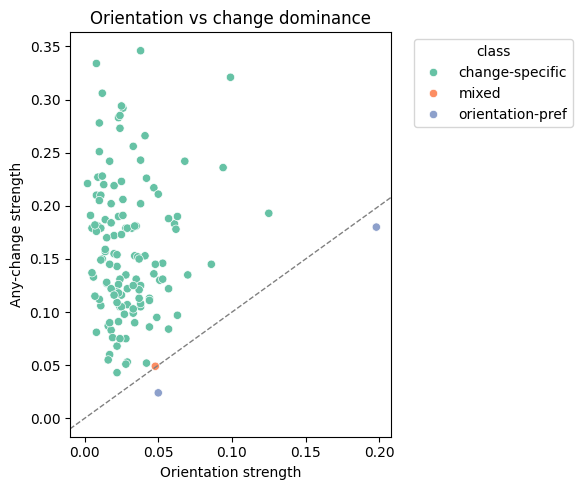

/var/folders/6s/3wb2h2qd7dj2dln0h5wk8bs40000gn/T/ipykernel_65146/4291504042.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classification_df,


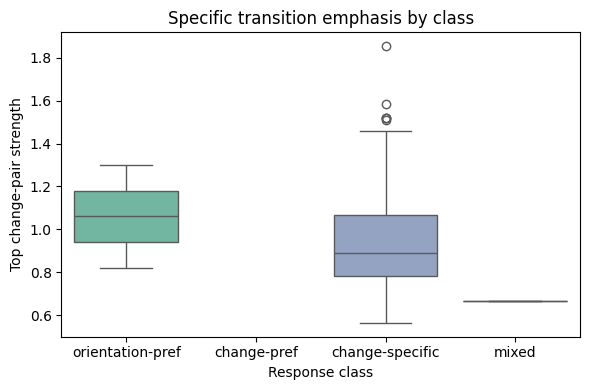

In [ ]:

import seaborn as sns

plt.figure(figsize=(6, 5))
sns.scatterplot(data=classification_df,
                x='orientation_strength',
                y='change_any_strength',
                hue='response_class',
                palette='Set2')
plt.axline((0,0), slope=1, color='grey', linestyle='--', linewidth=1)
plt.xlabel('Orientation strength')
plt.ylabel('Any-change strength')
plt.title('Orientation vs change dominance')
plt.legend(title='class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

if change_pair_names:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=classification_df,
                x='response_class',
                y='top_change_pair_strength',
                order=['orientation-pref', 'change-pref', 'change-specific', 'mixed'],
                palette='Set2')
    plt.xlabel('Response class')
    plt.ylabel('Top change-pair strength')
    plt.title('Specific transition emphasis by class')
    plt.tight_layout()
    plt.show()



### Rastermaps by model category

Use the model-based labels to highlight neurons for specific orientation transitions.


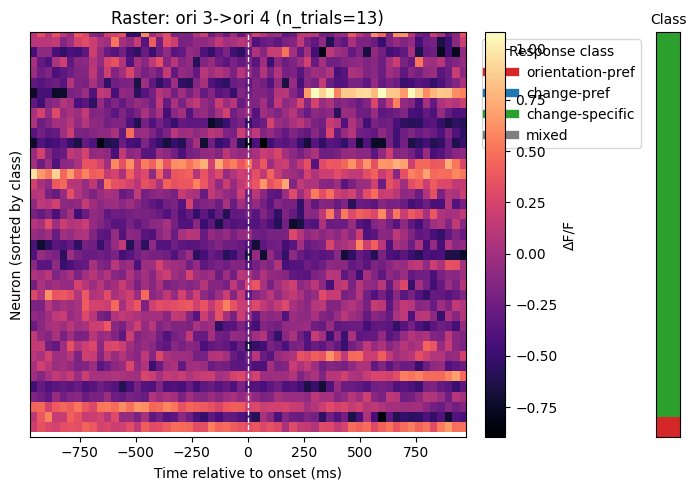

In [ ]:
from utils import plot_transition_rastermaps

# Example: adjust `change_label` to the transition of interest
plot_transition_rastermaps(
    classification_df=classification_df,
    Y_trials=Y_trials,
    trial_df=trial_df,
    time_vector_ms=design_context['time_vector_ms'],
    orientation_code_lookup=design_context.get('orientation_code_lookup', {}),
    orientation_labels=orientation_labels,
    change_label='ori 3->ori 4',
    top_k=40,
    window_ms=(-1000.0, 1000.0),
    cmap='magma'
)


### Interpreting the categories
- Points **above** the diagonal in the scatter plot are change-dominated; those **below** are orientation-dominated.
- `change-specific` neurons not only prefer change overall but also have a standout orientation pair (`top_change_pair`).
- `mixed` units have comparable orientation/change strengths and may require closer inspection (e.g., via PSTHs).

Use `classification_df` to filter neurons for downstream visualisations or anatomical overlays.


## 6) Quick plots (single-figure each; no custom colors)

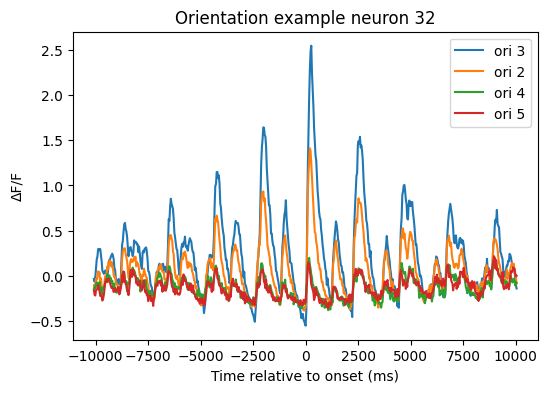

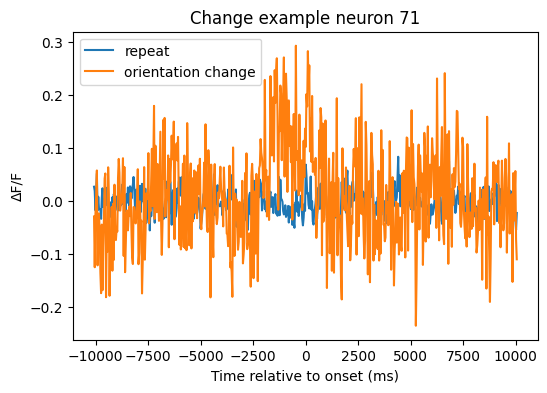

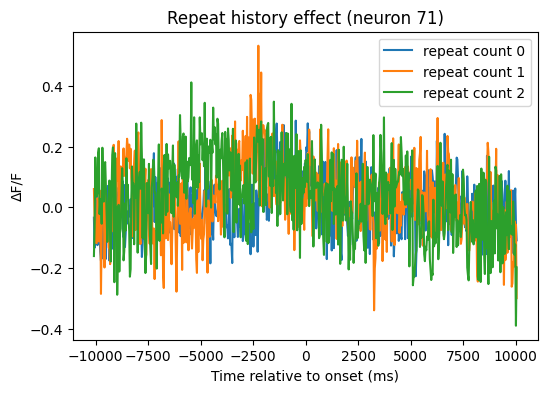

In [ ]:

# Illustration: average responses for the most orientation-tuned vs change-tuned neurons
if 'summary_df' in locals() and not summary_df.empty and Y_trials is not None:
    time_axis = design_context.get('time_vector_ms', np.arange(Y_trials.shape[1]))
    time_axis = np.asarray(time_axis)[:Y_trials.shape[1]]

    orient_idx = summary_df.sort_values('orientation_strength', ascending=False).iloc[0]['cell']
    change_idx = summary_df.sort_values('change_any_strength', ascending=False).iloc[0]['cell']

    trial_table = trial_df.copy()
    if 'theta_idx' not in trial_table and 'orientation_idx' in trial_table:
        trial_table['theta_idx'] = trial_table['orientation_idx']

    fig, ax = plt.subplots(figsize=(6, 4))
    for ori_idx, label in sorted(zip(trial_table['theta_idx'].unique(), orientation_labels)):
        trials_sel = trial_table.index[trial_table['theta_idx'] == ori_idx]
        trace = Y_trials[trials_sel, :, int(orient_idx)].mean(axis=0)
        ax.plot(time_axis, trace, label=label)
    ax.set_title(f'Orientation example neuron {int(orient_idx)}')
    ax.set_xlabel('Time relative to onset (ms)')
    ax.set_ylabel('ΔF/F')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 4))
    for flag, label in [(False, 'repeat'), (True, 'orientation change')]:
        trials_sel = trial_table.index[trial_table['is_transition'] == flag]
        if len(trials_sel) == 0:
            continue
        trace = Y_trials[trials_sel, :, int(change_idx)].mean(axis=0)
        ax.plot(time_axis, trace, label=label)
    ax.set_title(f'Change example neuron {int(change_idx)}')
    ax.set_xlabel('Time relative to onset (ms)')
    ax.set_ylabel('ΔF/F')
    ax.legend()
    plt.show()

    if 'repeat_count' in trial_table.columns and trial_table['repeat_count'].max() > 0:
        fig, ax = plt.subplots(figsize=(6, 4))
        for rep in sorted(trial_table['repeat_count'].unique())[:3]:
            trials_sel = trial_table.index[trial_table['repeat_count'] == rep]
            if len(trials_sel) == 0:
                continue
            trace = Y_trials[trials_sel][:, mask, int(change_idx)].mean(axis=0)
            ax.plot(time_axis, trace, label=f'repeat count {int(rep)}')
        ax.set_title(f'Repeat history effect (neuron {int(change_idx)})')
        ax.set_xlabel('Time relative to onset (ms)')
        ax.set_ylabel('ΔF/F')
        ax.legend()
        plt.show()
else:
    print('Summary data not available for quick plots.')




In [ ]:
# Inspect stimulus labels for the current session
codes, counts = np.unique(alignment['list_stim_labels'][alignment_session_idx][:, 2].astype(int), return_counts=True)
print('Stimulus codes and counts:', dict(zip(codes, counts)))

# Check the helper output
print('Transition trials in trial_df:', trial_df['is_transition'].sum(), '/', len(trial_df))
print('Unique pair labels:', trial_df['pair_label'].unique())

# Examine the change regressors after build_design_mats
change_any_norm = np.linalg.norm(design['any_change_fir'], axis=0)
print('Any-change FIR column norms:', change_any_norm)

if design['metadata']['change_pair_names']:
    pair_block = design['M2'][:, design['M1'].shape[1] : design['M1'].shape[1] + len(design['metadata']['change_pair_names'])*design['any_change_fir'].shape[1]]
    pair_norms = np.linalg.norm(pair_block, axis=0)
    print('Change-pair FIR column norms:', pair_norms)


# Rebuild the design and inspect the same norms after re-running the loader + design cells


Stimulus codes and counts: {np.int64(-5): np.int64(14), np.int64(-4): np.int64(13), np.int64(-3): np.int64(16), np.int64(-2): np.int64(14), np.int64(-1): np.int64(101), np.int64(2): np.int64(380), np.int64(3): np.int64(536), np.int64(4): np.int64(422), np.int64(5): np.int64(494)}
Transition trials in trial_df: 128 / 1889
Unique pair labels: ['start' 'ori 3->ori 2' 'repeat_ori 2' 'ori 2->ori 3' 'repeat_ori 3'
 'ori 2->ori 4' 'ori 4->ori 5' 'ori 5->ori 3' 'ori 3->ori 4'
 'ori 4->ori 3' 'ori 2->ori 5' 'ori 5->ori 2' 'repeat_ori 4'
 'ori 3->ori 5' 'repeat_ori 5' 'ori 5->ori 4' 'ori 4->ori 2']
Any-change FIR column norms: [11.3137 11.3137 11.3137 11.3137]
Change-pair FIR column norms: [11.3137 11.3137 11.3137 11.3137  3.1623  3.1623  3.1623  3.1623  2.8284
  2.8284  2.8284  2.8284  2.8284  2.8284  2.8284  2.8284  3.6056  3.6056
  3.6056  3.6056  3.3166  3.3166  3.3166  3.3166  3.6056  3.6056  3.6056
  3.6056  3.4641  3.4641  3.4641  3.4641  3.6056  3.6056  3.6056  3.6056
  3.6056  3.6056  3

In [ ]:
design_context['time_vector_ms'][:10]

array([-10080.431, -10047.073, -10013.46 ,  -9979.927,  -9946.044,
        -9912.421,  -9879.047,  -9845.429,  -9811.919,  -9778.041],
      dtype=float32)

In [ ]:
summary_df

,cell,orientation_strength,orientation_pref_deg,generic_onset_strength,change_any_strength,top_change_pair,top_change_pair_strength,repeat_onset_strength,repeat_level_coeff,intercept,dominant_effect,display_label,R2_M2
0,0,0.028,103.3,0.140,0.075,ori 3->ori 5,0.589,0.007,-0.001,0.009119,change_pair,cell 0,-0.001
1,1,0.057,44.9,0.064,0.084,ori 4->ori 2,0.597,0.002,-0.001,0.002964,change_pair,cell 1,-0.000
2,2,0.017,104.1,0.179,0.060,ori 4->ori 2,0.783,0.006,0.000,0.006772,change_pair,cell 2,-0.000
3,3,0.050,30.5,0.072,0.024,ori 5->ori 3,0.820,0.002,-0.001,0.002533,change_pair,cell 3,-0.000
4,4,0.022,94.8,0.169,0.068,ori 2->ori 3,1.212,0.005,-0.002,0.003223,change_pair,cell 4,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,125,0.020,48.5,0.064,0.116,ori 3->ori 5,0.830,0.002,-0.000,0.000951,change_pair,cell 125,-0.000
126,126,0.024,148.1,0.085,0.273,ori 3->ori 4,0.894,0.004,0.000,0.001691,change_pair,cell 126,-0.000
127,127,0.018,112.6,0.139,0.184,ori 3->ori 4,0.737,0.005,0.000,-0.002305,change_pair,cell 127,-0.000
128,128,0.007,26.4,0.080,0.182,ori 2->ori 4,1.027,0.004,0.001,-0.000872,change_pair,cell 128,-0.000


In [ ]:
import importlib, utils
importlib.reload(utils)

<module 'utils' from '/Users/davisgrubin/2p_imaging/passive_interval_oddball_202412/utils.py'>

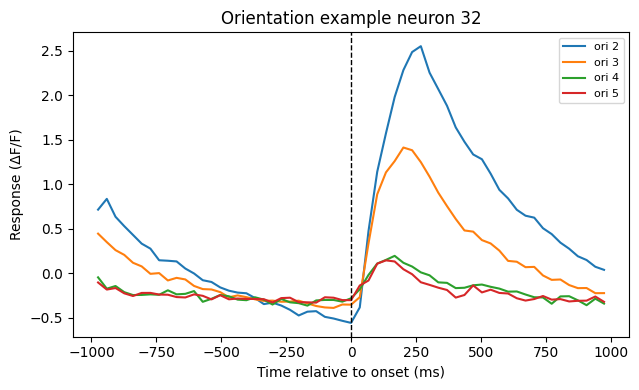

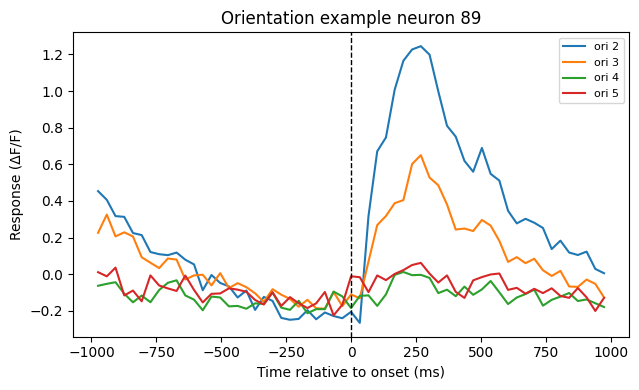

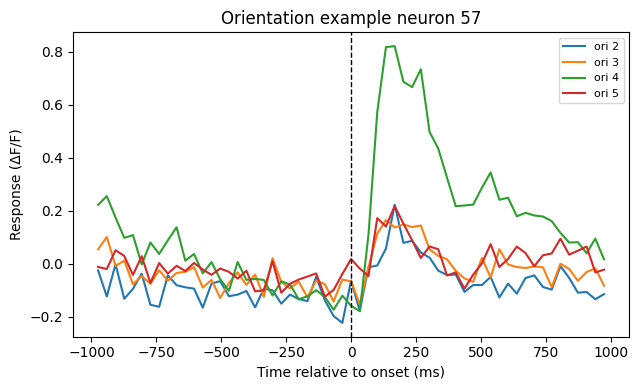

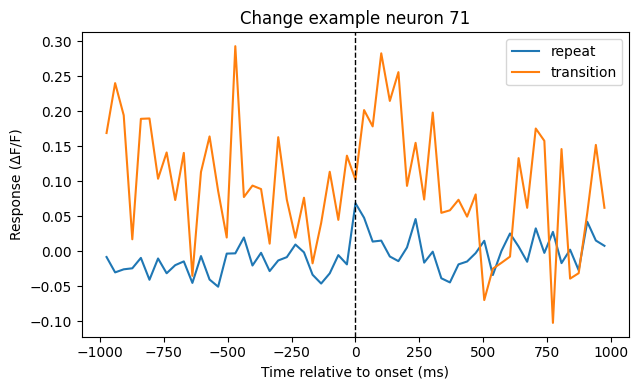

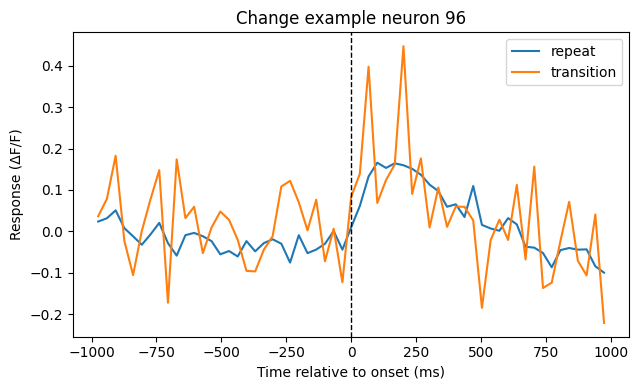

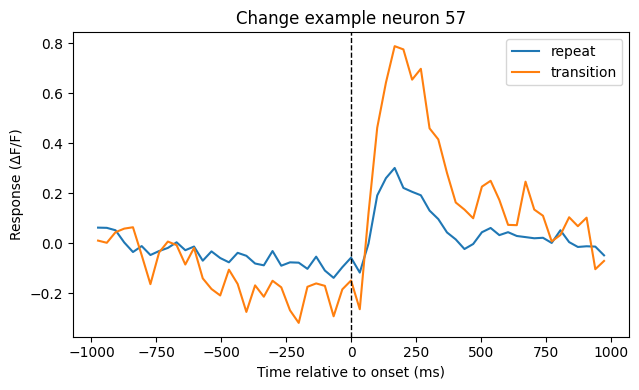

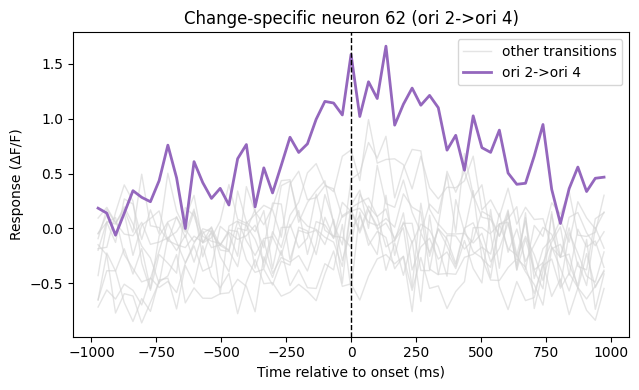

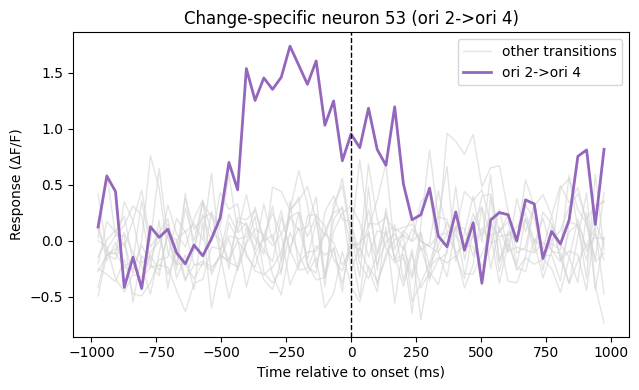

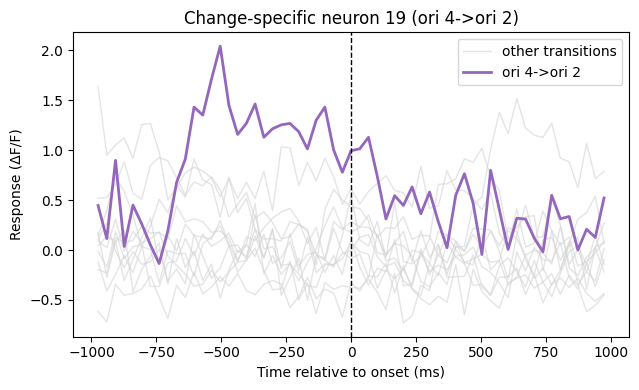

In [ ]:
from utils import plot_top_orientation_neurons, plot_top_transition_neurons, plot_top_change_specific_neurons

plot_top_orientation_neurons(summary_df, Y_trials, trial_df, design_context['time_vector_ms'], design_context['orientation_labels'], top_n=)
plot_top_transition_neurons(summary_df, Y_trials, trial_df, design_context['time_vector_ms'], top_n=3)
plot_top_change_specific_neurons(summary_df, Y_trials, trial_df, design_context['time_vector_ms'], top_n=3, include_other_pairs=True)


$$
\begin{aligned}
\eta_n(t)
  &= \beta_{0n}
   + \boldsymbol{\beta}^{\text{ori}}_n \cdot
      \begin{bmatrix} \cos\!\left(2\theta_t\right) \\[2pt] \sin\!\left(2\theta_t\right) \end{bmatrix}
   + \sum_{\ell=0}^{L-1} \gamma_{\ell n}\, u_{t-\ell} \\
  &\quad + \sum_{\ell=0}^{L-1} \delta_{\ell n}\, c_{t-\ell}
   + \sum_{k \in \mathcal{K}}
      \sum_{\ell=0}^{L-1} \delta_{k\ell n}\, c_{k,t-\ell}
\end{aligned}
$$

$$
y_n(t) \sim
\begin{cases}
  \mathcal{N}\!\left(\eta_n(t),\, \sigma_n^2\right)   & \text{for }\Delta F/F .
\end{cases}
$$

\begin{array}{ll}
\beta_{0n} & \text{baseline for neuron } n. \\
\boldsymbol{\beta}^{\text{ori}}_n & \text{late orientation tuning (steady response).} \\
u_t & \text{stimulus-onset indicator (1 at onset, 0 otherwise); }\gamma_{\ell n} \text{ is the onset FIR.} \\
c_t & \text{“any change” indicator (1 if current trial is a transition); }\delta_{\ell n} \text{ is its FIR.} \\
c_{k,t} & \text{pair-specific indicator for transition } k \in \mathcal{K} \text{ (e.g.\ }\text{ori }3\!\rightarrow\!4\text{).} \\
& \quad \delta_{k\ell n} \text{ captures neurons selective for that specific change.} \\
\theta_t & \text{grating orientation at time } t;\; g(\theta_t) = [\cos(2\theta_t), \sin(2\theta_t)]. \\
\eta_n(t) & \text{linear predictor; }\;L\text{ is FIR length (typically 4 lags ≈ 120 ms).}
\end{array}


In [ ]:
T = 10
L = 4

# 1) Orientation indicator: a particular orientation is “on” during bins 2–5
ori_indicator = np.zeros(T, dtype=int)
ori_indicator[2:6] = 1

# 2) Transition indicator: a change happens at bin 6
change_indicator = np.zeros(T, dtype=int)
change_indicator[6] = 1

# 3) Pair-specific indicator: the change is “ori 3 → ori 4” at bin 6
pair_indicator = np.zeros(T, dtype=int)
pair_indicator[6] = 1  # same change bin

# Stimulus-on mask (only bins 2–6 contain the stimulus)
stim_mask = np.zeros(T, dtype=int)
stim_mask[2:7] = 1

def fir_columns(indicator, L):
    """Identity FIR basis. Column ℓ is indicator shifted ℓ bins."""
    cols = []
    for lag in range(L):
        col = np.zeros_like(indicator, dtype=float)
        if lag == 0:
            col = indicator.copy()
        else:
            col[lag:] = indicator[:-lag]
        cols.append(col)
    return np.column_stack(cols)

# Build FIR columns and apply mask (orientation gated by mask_float)
ori_fir_raw = fir_columns(ori_indicator, L)
ori_fir = ori_fir_raw * stim_mask[:, None]

change_fir_raw = fir_columns(change_indicator, L)
change_fir = change_fir_raw * stim_mask[:, None]

pair_fir_raw = fir_columns(pair_indicator, L)
pair_fir = pair_fir_raw * stim_mask[:, None]

def frame(label, base, fir):
    df = pd.DataFrame(
        np.column_stack([base, fir]),
        columns=[label] + [f"{label}_lag{lag}" for lag in range(L)],
    )
    return df

display(frame("orientation", ori_indicator, ori_fir))
display(frame("change_any", change_indicator, change_fir))
display(frame("change_pair", pair_indicator, pair_fir))
print("Stimulus mask:", stim_mask)


,orientation,orientation_lag0,orientation_lag1,orientation_lag2,orientation_lag3
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,1.0,1.0,1.0
6,0.0,0.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


,change_any,change_any_lag0,change_any_lag1,change_any_lag2,change_any_lag3
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


,change_pair,change_pair_lag0,change_pair_lag1,change_pair_lag2,change_pair_lag3
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0


Stimulus mask: [0 0 1 1 1 1 1 0 0 0]
